# CH6. MDP 정책을 모를때 최고의 정책 찾기
- 코드 부분

### 몬테카를로 컨트롤

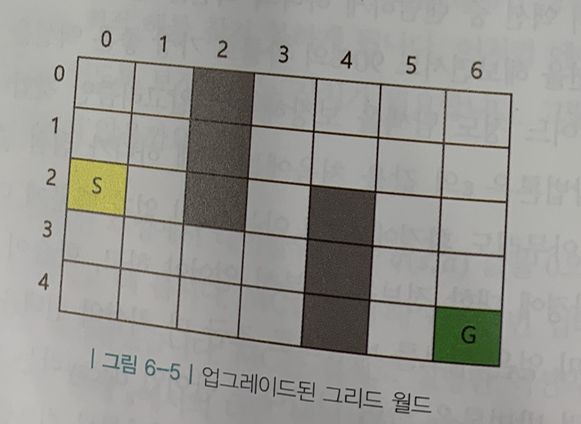

In [2]:
from IPython.display import Image
Image('./image/6-1.png')

- S에서 출발하여 G에 도착하면 끝
- 회색 영역은 지나갈 수 없는 벽이 놓여 있는 곳
- 보상은 스텝마다 -1(즉 최단 거리로 G에 도달하는 것이 목적)

- 여기서는 간략화된 정책 이터레이션(평가와 개선 단계를 끝까지 진행하지 않고 아주 얕에 진행하는 방식)을 사용한다.
- 기존의 정책 이터레이션이 평가 단계를 수혐할때까지 진행했던 것과 다르게 평가 단계에서 업데이트를 굳이 수혐할 때 까지 하지 않고 일단 가치 테이블에 저장해둔 값들이 조금이라도 바뀌면 그에 대해서 개선 정책 단계를 진행할 수 있다.

1. 수렴할 때 까지 n번 반복
    - 한 에피소드의 경험을 쌓고
    - 경험한 데이터로 q(s,a) 테이블의 값을 업데이트 하고(정책 평가)
    - 업데이트된 q(s,a) 테이블을 이용하여 ε-greedy 정책을 만들고(정책 개선)

In [4]:
# 라이브러리

import random
import numpy as np # q(s,a)를 담아두기 위해 활용

In [17]:
# GridWordl 클래스

class GridWorld():
    '''
    환경에 대한 함수 클래스
    '''
    def __init__(self):
        self.x=0
        self.y=0
    
    def step(self, a):
        # 0번 액션: 왼쪽, 1번 액션: 위, 2번 액션: 오른쪽, 3번 액션: 아래쪽
        if a==0:
            self.move_left()
        elif a==1:
            self.move_up()
        elif a==2:
            self.move_right()
        elif a==3:
            self.move_down()

        reward = -1  # 보상은 항상 -1로 고정
        done = self.is_done()
        return (self.x, self.y), reward, done

    def move_left(self):
        if self.y==0:
            pass
        elif self.y==3 and self.x in [0,1,2]:
            pass
        elif self.y==5 and self.x in [2,3,4]:
            pass
        else:
            self.y -= 1

    def move_right(self):
        if self.y==1 and self.x in [0,1,2]:
            pass
        elif self.y==3 and self.x in [2,3,4]:
            pass
        elif self.y==6:
            pass
        else:
            self.y += 1
      
    def move_up(self):
        if self.x==0:
            pass
        elif self.x==3 and self.y==2:
            pass
        else:
            self.x -= 1

    def move_down(self):
        if self.x==4:
            pass
        elif self.x==1 and self.y==4:
            pass
        else:
            self.x+=1

    def is_done(self):
        if self.x==4 and self.y==6: # 목표 지점인 (4,6)에 도달하면 끝난다
            return True
        else:
            return False
      
    def reset(self):
        self.x = 0
        self.y = 0
        return (self.x, self.y)

In [18]:
# QAgent 클래스

class QAgent():
    def __init__(self):
        self.q_table = np.zeros((5,7,4)) # q밸류를 저장하는 변수, 모두 0으로 초기화
        self.eps = 0.9 # 입실론 설정
        self.alpha = 0.01
        
    def select_action(self, s):
        # eps-greedy로 액션을 선택
        x, y = s
        coin = random.random()
        if coin < self.eps:
            action = random.randint(0,3)
        else:
            action_val = self.q_table[x,y,:]
            action = np.argmax(action_val)
        return action
    
    def update_table(self, history):
        # 한 에피소드에 해당하는 history를 입력으로 받아 q 테이블의 값을 업데이트 한다.
        cum_reward = 0
        for transition in history[::-1]:
            s, a, r, s_prime = transition
            x, y = s
            # 몬테카를로 방식을 이용하여 업데이트
            self.q_table[x,y,a] = self.q_table[x,y,a] + self.alpha * (cum_reward - self.q_table[x,y,a])
            cum_reward = cum_reward + r
            
    def anneal_eps(self):
        self.eps -= 0.03
        self.eps = max(self.eps, 0.1)
        
    def show_table(self):
        # 학습이 각 위치에서 어느 액션의 q 값이 가장 높았는지 보여주는 함수
        q_lst = self.q_table.tolist()
        data = np.zeros((5,7))
        for row_idx in range(len(q_lst)):
            row = q_lst[row_idx]
            for col_idx in range(len(row)):
                col = row[col_idx]
                action = np.argmax(col)
                data[row_idx, col_idx] = action
        print(data)

In [21]:
# 메인 함수

def main():
    env = GridWorld()
    agent = QAgent()
    
    for n_epi in range(1000) : # 총 n 에피소드 동안 학습
        done = False
        history = []
        
        s = env.reset()
        while not done: # 한 에피소드가 끝날 때 까지
            a = agent.select_action(s)
            s_prime, r, done = env.step(a)
            history.append((s, a, r, s_prime))
            s = s_prime
        agent.update_table(history) # 히스토리를 이용하여 에이전트를 업데이트
        agent.anneal_eps()
    
    agent.show_table()

In [22]:
main()

[[3. 3. 0. 3. 1. 2. 2.]
 [3. 0. 0. 2. 2. 3. 3.]
 [2. 3. 0. 1. 0. 2. 3.]
 [3. 2. 2. 1. 0. 2. 3.]
 [1. 2. 0. 2. 0. 2. 0.]]


- 위의 결과를 그림으로 표현하면 아래의 이미지로 표현 할 수 있다.

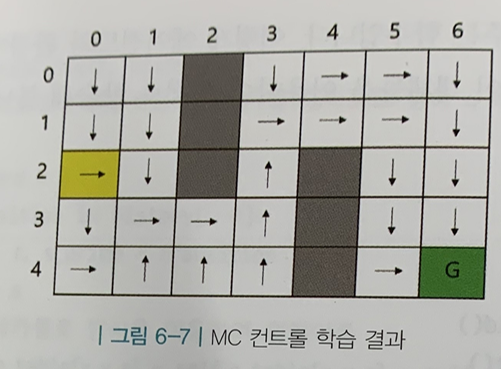

In [23]:
Image('./image/6-2.png')

### TD 컨트롤 1 - SARSA

In [27]:
# QAgent 클래스

class QAgent():
    def __init__(self):
        self.q_table = np.zeros((5,7,4)) # 마찬가지로 Q테이블을 모두 0으로 초기화
        self.eps = 0.9 # 입실론 설정
        
    def select_action(self, s):
        x, y = s
        coin = random.random()
        if coin < self.eps:
            action = random.randint(0,3)
        else:
            action_val = self.q_table[x,y,:]
            action = np.argmax(action_val)
        return action
    
    def update_table(self, transition):
        s, a, r, s_prime = transition
        x, y = s
        next_x, next_y = s_prime
        a_prime = self.select_action(s_prime) # s'에서 선택할 액션(실제로 취한 액션이 아님)
        
        # SARSA 엡데이트 식을 이용
        self.q_table[x,y,a] = self.q_table[x,y,a] + 0.1 * (r + self.q_table[next_x, next_y, a_prime] - self.q_table[x,y,a])
        
        
    def anneal_eps(self):
        self.eps -= 0.03
        self.eps = max(self.eps, 0.1)
        
    def show_table(self):
        q_lst = self.q_table.tolist()
        data = np.zeros((5,7))
        for row_idx in range(len(q_lst)):
            row = q_lst[row_idx]
            for col_idx in range(len(row)):
                col = row[col_idx]
                action = np.argmax(col)
                data[row_idx, col_idx] = action
        print(data)

- 나머지는 그대로이지만 update_table의 함수가 바뀌었다.
- MC에서는 update_table 함수가 에이전트가 경험한 history 전체를 인자로 받았지만, 이제는 트랜지션(상태 전이 1번을 뜻함)을 인풋으로 받는다.
- 상태 s에서 a를 해서 보상 r을 받고 상태 s'에 도달했다면 (s,a,r,s')이 하나의 트랜지션이다.
- TD 학습은 샘플 하나만 생기면 바로 업데이트할 수 있기 때문에 history 대신 트랜지션을 업데이트 하는 방식으로 바뀐것이다.

In [28]:
# 메인 함수

def main():
    env = GridWorld()
    agent = QAgent()
    
    for n_epi in range(1000) : # 총 n 에피소드 동안 학습
        done = False
        
        s = env.reset()
        while not done: # 한 에피소드가 끝날 때 까지
            a = agent.select_action(s)
            s_prime, r, done = env.step(a)
            agent.update_table((s,a,r,s_prime))
            s = s_prime
        agent.anneal_eps()
    
    agent.show_table()

In [29]:
main()

[[2. 3. 0. 1. 3. 2. 3.]
 [3. 3. 0. 2. 2. 3. 3.]
 [2. 3. 0. 1. 0. 3. 3.]
 [2. 2. 2. 1. 0. 3. 3.]
 [3. 3. 2. 1. 0. 2. 0.]]


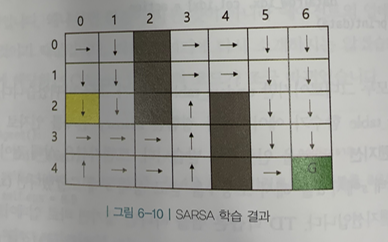

In [30]:
Image('./image/6-3.png')

### TD 컨트롤 2 - Q러닝

In [31]:
# QAgent 클래스

class QAgent():
    def __init__(self):
        self.q_table = np.zeros((5,7,4)) # 마찬가지로 Q테이블을 모두 0으로 초기화
        self.eps = 0.9 # 입실론 설정
        
    def select_action(self, s):
        x, y = s
        coin = random.random()
        if coin < self.eps:
            action = random.randint(0,3)
        else:
            action_val = self.q_table[x,y,:]
            action = np.argmax(action_val)
        return action
    
    def update_table(self, transition):
        s, a, r, s_prime = transition
        x, y = s
        next_x, next_y = s_prime
        # Q러닝 업데이트 식을 이용
        self.q_table[x,y,a] =self.q_table[x,y,a]+0.1*(r + np.argmax(self.q_table[next_x,next_y,:]) - self.q_table[x,y,a])
        
    def anneal_eps(self):
        self.eps -= 0.01
        self.eps = max(self.eps, 0.2)
        
    def show_table(self):
        q_lst = self.q_table.tolist()
        data = np.zeros((5,7))
        for row_idx in range(len(q_lst)):
            row = q_lst[row_idx]
            for col_idx in range(len(row)):
                col = row[col_idx]
                action = np.argmax(col)
                data[row_idx, col_idx] = action
        print(data)

In [ ]:
main()

In [ ]:
Image('./image/6-4.png')